# EDA on meta informations in tweets

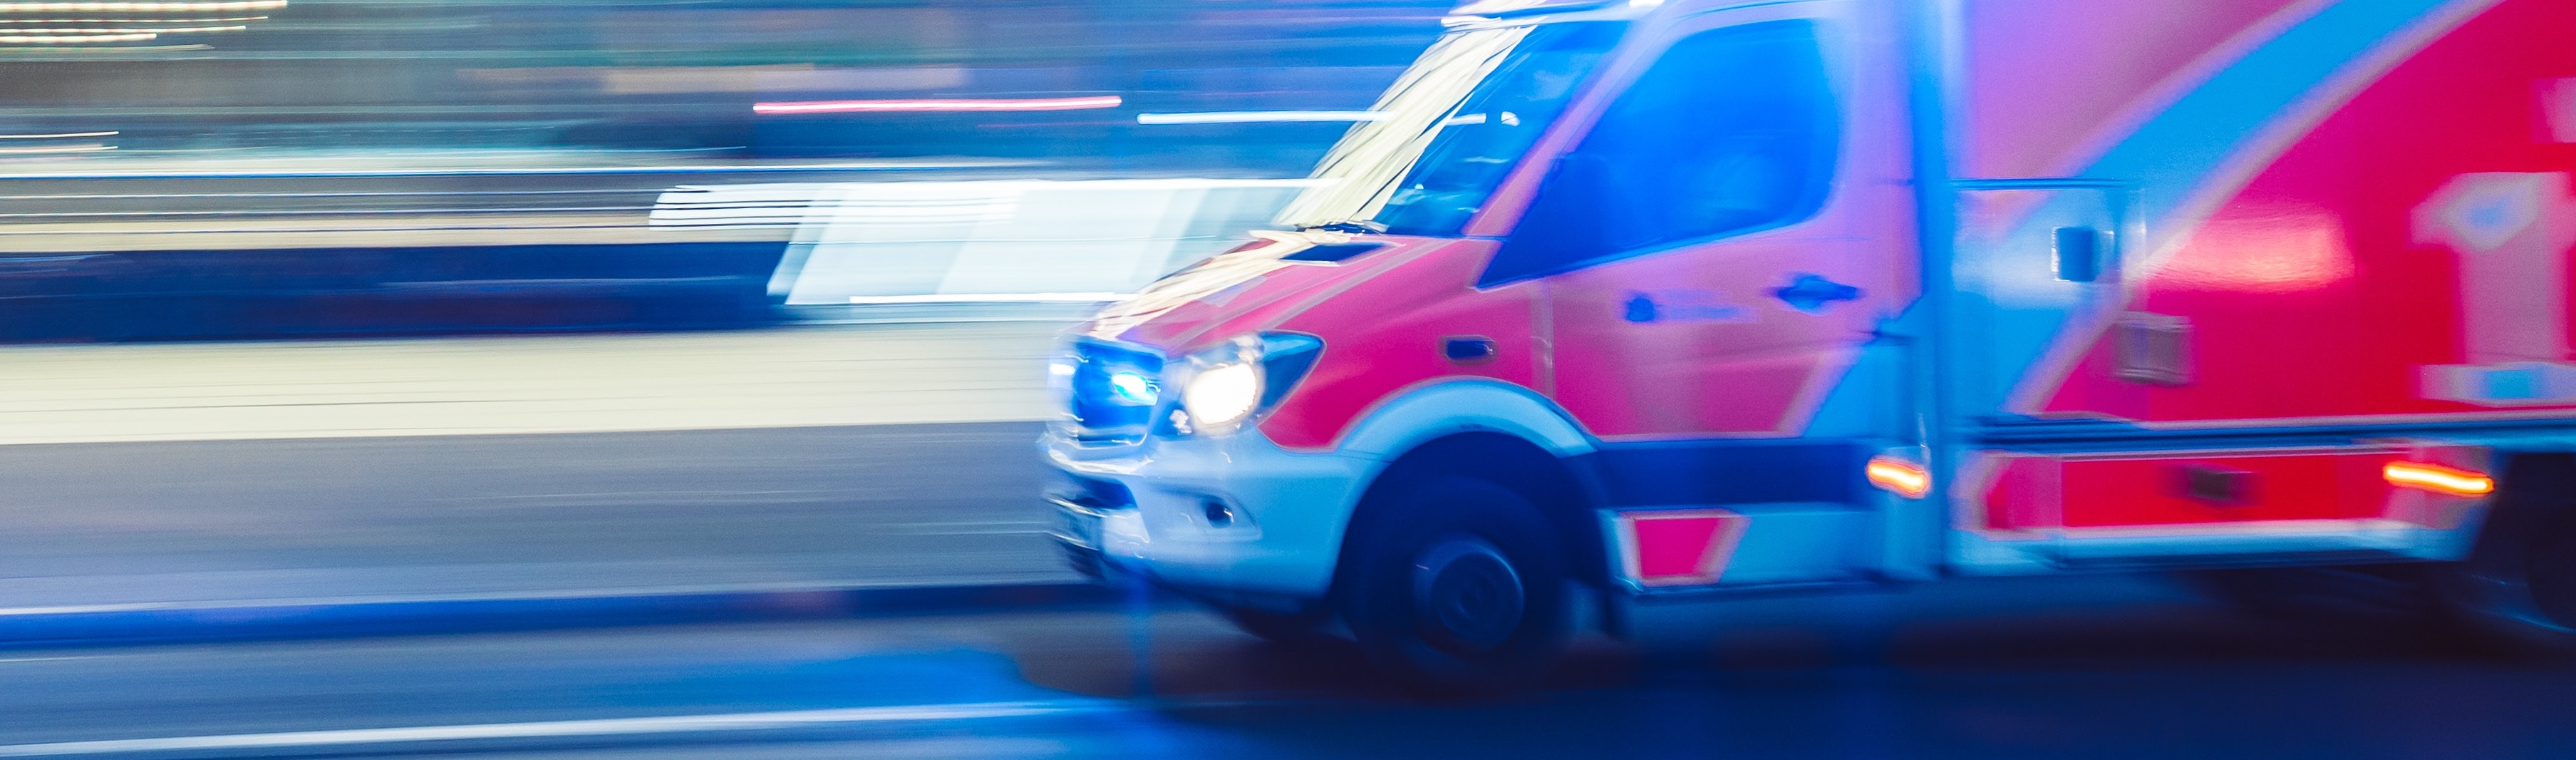

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

Introduction and References
EDA and approach on meta information in tweets. We have tried a combination of tf-idf vectors along with meta information in another notebook [NLP Disaster Predict - shallow ml approaches](https://www.kaggle.com/vivekam101/nlp-disaster-predict-shallow-ml-approaches)

This kernel includes codes and ideas from kernels below. If this kernel helps you, please upvote their work as well.

References: 
[Simple Exploration Notebook - QIQC](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) by [@sudalairajkumar](https://www.kaggle.com/sudalairajkumar)


# Load libraries

Install Plotly

In [ ]:
pip install plotly==4.14.3

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import plotly.graph_objects as go
from plotly import tools
import plotly.offline as py
import matplotlib.pyplot as plt
import string
import seaborn as sns

In [ ]:
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")

# Analyze Data

In [ ]:
train_df.shape

In [ ]:
train_df.head()

In [ ]:
print("samples with disaster tweet:", sum(train_df['target']==1))
print("samples without disaster tweet:", sum(train_df['target']==0))

In [ ]:
test_df.head()

# Check for unbalanced classes

In [ ]:
## target count ##
cnt_srs = train_df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")


> Classes are almost balanced and good to go.

# Look at frequency of words

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["text"], title="Word Cloud of Questions")

> words like earthquakes, forest, fire are most frequent and yes are disaster tweets

# Word Frequency plot in each classes

In [ ]:
from collections import defaultdict
stopwords = set(STOPWORDS)
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', '-', '...', '|', '&', '?', '??', 'via', '2'}
stopwords = stopwords.union(more_stopwords)
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from non disaster tweet ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from disaster tweets ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non disaster tweets", 
                                          "Frequent words of disaster tweets"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')


* fire, suicide, police are all relevant for disaster
* will, new, now, body are having high values for non disaster which is suprising 

Bigram Frequency

In [ ]:
freq_dict = defaultdict(int)
stopwords = set(STOPWORDS)
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', '-', '...', '|', '&', '?', '??', 'via', '2'}
stopwords = stopwords.union(more_stopwords)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non disaster tweets", 
                                          "Frequent words of disaster tweets"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

> Again disaster tweets are visibly making sense from bigrams as well

# Meta Feature Analysis

Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are
```
Number of words in the text
Number of unique words in the text
Number of characters in the text
Number of stopwords
Number of punctuations
Number of upper case words
Number of title case words
Average length of the words
```

In [ ]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
## Truncate some extreme values for better visuals ##
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

> Looks like number of punctuations and charactors in disaster tweets are more than that of not. may be more information about the disaster to spread to all.

> Building Base Model making use of meta informations

In [ ]:
features = ['num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper', 'num_words_title', 'mean_word_len']
train_vectors = train_df[features].values
test_vectors = train_df[features].values

In [ ]:
from sklearn import metrics
train_y = train_df["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_vectors[dev_index], train_vectors[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_vectors)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

In [ ]:
cv_scores

In [ ]:
for thresh in np.arange(0.3, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

Here we have used only meta informations to build the model ignoring word or text importance as such. 

# Conclusion

* We found that meta informations like punctuations and charactor length are more in case of disaster tweets
* Including meta informations also along with tf-idf vectors may help to improve the model
* We have tried a combination of tf-idf vectors along with meta information in another notebook [NLP Disaster Predict - shallow ml approaches](https://www.kaggle.com/vivekam101/nlp-disaster-predict-shallow-ml-approaches)

* We will try to get contextual information using transformer models in another notebook. Please upvote if you find it useful.
